IN THE NAME OF  ALLAH , THE MOST GRACIOUS, THE MOST MERCIFUL.

In Sha Allah

Aim: train model for subway surfers\
    4 gestures (up,down,left,right)\
Model takes videos as sequence of image

Train RNN on custom data.

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"   # to prevent kernel dying when using matplotlib with pytorch

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import sampler
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder

import torchvision.transforms as T
import torch.nn.functional as F

FOLDER = "C:/Users/PMLS/FYP"
dtype = torch.float32

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print("Device used:", device)

Device used: cpu


In [7]:
class ThreeLayerRNN(nn.Module):
    def __init__(self, input_size, size1, size2, num_classes):
        # define layers of nn
        super().__init__()
        self.layer1 = nn.RNN(input_size, size1)
        self.layer2 = nn.RNN(size1, size2)
        self.layer3 = nn.RNN(size2, num_classes)

    def forward(self, x):
        # Implement the forward function (connect the layers)
        out1 = F.relu(self.layer1(x)[0])
        out2 = F.relu(self.layer2(out1)[0])
        scores = self.layer3(out2)[0]

        return scores   # for each image, model gives a score to each class

In [3]:
# Prepare custom dataset
def flatten(x):
    # Convert multidimensional matrix to 2D matrix (Nxd)
    # i.e convert input into a 1d vector per sample
    return x.view(len(x), -1)

# Preprocessing on images
size = 32
transforms = T.Compose([T.ToTensor(),
                       T.Resize([size,size])
                       ])
# Load images from folder
dataset = ImageFolder(f"{FOLDER}/custom_tayyab/combined_image/", transform = transforms)

custom_classmap = {0:"click",1:"up",2:"left",3:"up"}

train_dataset, valid_dataset, test_dataset = random_split(dataset, [0.7,0.2,0.1])
batch_size = 4

custom_train_loader = DataLoader(train_dataset, batch_size=batch_size,  shuffle=True)
custom_valid_loader = DataLoader(valid_dataset, batch_size=batch_size,  shuffle=True)
custom_test_loader = DataLoader(test_dataset,   batch_size=batch_size,  shuffle=True)

In [8]:
%%time

# Train on custom dataset
def train_model(model, data, epochs):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    all_loss = []
    for e in range(epochs):
        for t, (x, y) in enumerate(data):
            x = x.to(device)
            model.train()  # put model to training mode
            x = flatten(x)
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device)

            scores = model(x)
            loss = Loss_function(scores, y)

            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

        if e % (max(epochs//10, 1)) == 0:
            print('اللھم صل علی محمد و علی ال محمد   Iteration %d, loss = %.4f' % (e, loss.item()))
            all_loss.append(loss.item())
    #plt.plot(all_loss)
    print("Training complete 😊")

model = ThreeLayerRNN(3*size*size,12,8,10)
Loss_function =  F.cross_entropy

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
train_model(model, custom_train_loader, 5)

اللھم صل علی محمد و علی ال محمد   Iteration 0, loss = 1.8351
اللھم صل علی محمد و علی ال محمد   Iteration 1, loss = 2.0721
اللھم صل علی محمد و علی ال محمد   Iteration 2, loss = 1.8224
اللھم صل علی محمد و علی ال محمد   Iteration 3, loss = 1.6956
اللھم صل علی محمد و علی ال محمد   Iteration 4, loss = 1.6945
Training complete 😊
CPU times: total: 19.6 s
Wall time: 46 s


In [38]:
# Validation testing model
def check_accuracy_part34(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            x = flatten(x)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()            
        num_samples = batch_size*len(loader)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
check_accuracy_part34(custom_valid_loader, model)

Got 29 / 80 correct (36.25)


prediction = left, label = left


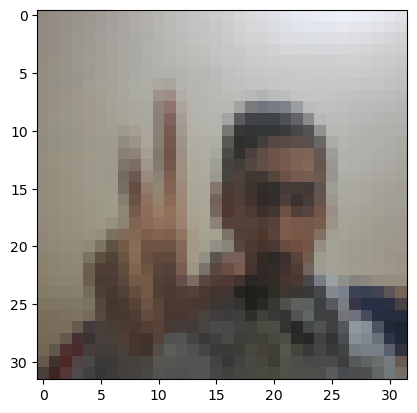

In [61]:
# Manual testing of model
# Pick random image from test dataset
model.eval()
with torch.no_grad():
    for t, (x, y) in enumerate(custom_test_loader):
        x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        y = y.to(device=device, dtype=torch.long)
        xf = flatten(x)
        scores = model(xf)
        _, preds = scores.max(1)
        print(f"prediction = {custom_classmap[int(preds[0])]}, label = {custom_classmap[int(y[0])]}")
        image = x[0].permute(1, 2, 0).numpy()
        plt.imshow(image)
        break